# **Research Notebook 06: Explainable AI (XAI) with LIME**

**Objective:** Implement LIME (Local Interpretable Model-agnostic Explanations) to explain *why* our fine-tuned DistilBERT model classifies specific articles as Real or Fake.

In [1]:
# Install Dependencies

!pip install -q lime transformers accelerate

In [2]:
# Import Libraries

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
import re

from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification
)

from lime.lime_text import LimeTextExplainer

In [3]:
# Mount Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Setting up environment

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [6]:
# Define File Paths

base_path = '/content/drive/MyDrive/Research/'
test_path = f'{base_path}datasets/test_dataset_clean.csv'
bert_path = f'{base_path}models/distilbert_finetuned_cased'
images_path = f'{base_path}images/'

In [7]:
# Load Fine-Tuned DistilBERT Model

print("Loading fine-tuned DistilBERT model...")

tokenizer = DistilBertTokenizerFast.from_pretrained(bert_path)
model = DistilBertForSequenceClassification.from_pretrained(bert_path)

model.to(device)
model.eval()

print("\nModel and tokenizer loaded successfully.")

Loading fine-tuned DistilBERT model...

Model and tokenizer loaded successfully.


In [8]:
# Robust Preprocessing (Matching Training Pipeline)

# We use the robust cleaning logic here to ensure the LIME explainer "sees" the text exactly as the model saw it during training.

def agent_preprocess_pipeline(text):
    """
    Robust preprocessing for the AI Agent.
    Matches the 'base_article_cleaner' used in training.
    """
    if not isinstance(text, str):
        return ""

    # --- Remove Reuters-style datelines (headers) ---
    text = re.sub(
        r'^[A-Z\s\/,.\-]+\s*\(reuters\)\s*[—-]*\s*',
        ' ',
        text,
        flags=re.IGNORECASE
    )

    # --- Remove Reuters source link footers ---
    text = re.sub(
        r'\[\d+\s+est\].*$',
        ' ',
        text,
        flags=re.IGNORECASE
    )

    # --- Remove trailing attribution footers ---
    text = re.sub(
        r'(?:via|read more):\s*[A-Za-z0-9\s\.]+$',
        ' ',
        text,
        flags=re.IGNORECASE
    )

    # --- Remove trailing image-credit boilerplate ---
    text = re.sub(
        r'(read more:)?\s*(featured image|image|photo)\s*(by|via)\s*.*$',
        ' ',
        text,
        flags=re.IGNORECASE
    )

    # --- Remove media credit providers ---
    text = re.sub(
        r'\b(getty images?|ap images?|afp|stringer)\b',
        ' ',
        text,
        flags=re.IGNORECASE
    )

    # --- Remove URLs and short links ---
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    text = re.sub(r'bit\.ly/\S+', ' ', text)

    # --- Normalize whitespace ---
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [9]:
# Define Prediction Function for LIME

print("Defining LIME prediction function...")

def predictor(texts):
    """
    LIME-compatible prediction function.
    Wraps the full pipeline: Preprocessing -> Tokenization -> Inference
    """

    # 1. Apply SAME robust preprocessing as training
    # This ensures LIME perturbations don't re-introduce noise
    texts = [agent_preprocess_pipeline(t) for t in texts]

    # 2. Tokenization
    inputs = tokenizer(
        texts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=512
    )

    # 3. Move to GPU
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # 4. Inference
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = F.softmax(logits, dim=-1)

    # 5. Return NumPy array (Required by LIME)
    return probs.cpu().numpy()


# Sanity check
print("\nRunning predictor sanity check...")
dummy_text = ["The president signed the bill today via Reuters."]
dummy_probs = predictor(dummy_text)
print(f"Output shape: {dummy_probs.shape} (Expected: [1, 2])")
print(f"Probabilities [Fake, Real]: {dummy_probs}")

Defining LIME prediction function...

Running predictor sanity check...
Output shape: (1, 2) (Expected: [1, 2])
Probabilities [Fake, Real]: [[0.01675908 0.9832409 ]]


In [10]:
# Initialize LIME Explainer

print("\Initializing LIME Text Explainer...")

class_names = ['Fake', 'Real']

explainer = LimeTextExplainer(
    class_names=class_names,
    bow=False  # Respects word order (better for Transformers)
)

print("\nLIME explainer initialized.")

\Initializing LIME Text Explainer...

LIME explainer initialized.


<>:3: SyntaxWarning: invalid escape sequence '\I'
<>:3: SyntaxWarning: invalid escape sequence '\I'
/tmp/ipython-input-1270036886.py:3: SyntaxWarning: invalid escape sequence '\I'
  print("\Initializing LIME Text Explainer...")


In [12]:
# Select Test Articles to Explain

print("Selecting test samples for explanation...")

df_test = pd.read_csv(test_path)
df_test = df_test.dropna(subset=['preprocessed_text_bert'])

# Select examples (2 Real, 2 Fake)
real_examples = df_test[df_test['label'] == 'real'] \
    ['preprocessed_text_bert'].head(2).tolist()

fake_examples = df_test[df_test['label'] == 'fake'] \
    ['preprocessed_text_bert'].head(2).tolist()

examples_to_explain = real_examples + fake_examples
true_labels = ['Real', 'Real', 'Fake', 'Fake']

print(f"\nSelected {len(examples_to_explain)} articles.")

Selecting test samples for explanation...

Selected 4 articles.


Generating LIME explanations...

--- Explaining Example 1 ---
True Label: Real
Text Snippet: The United States on Monday described as “troubling” an Israeli bill supported by a ministerial committee allowing settlers in the occupied West Bank to remain in homes built on private Palestinian la...
Prediction Probabilities -> Fake: 0.0001, Real: 0.9999



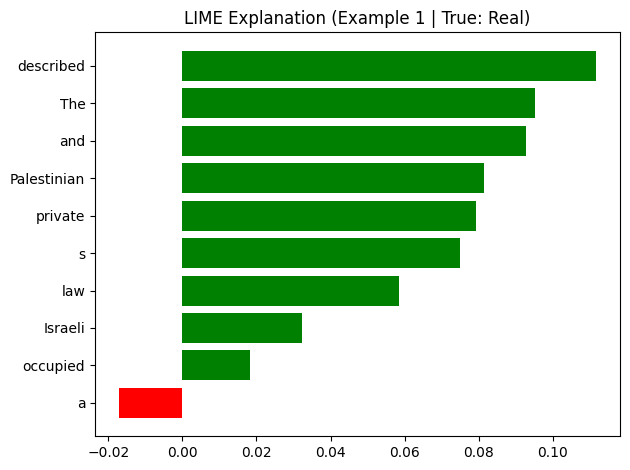

Top Influential Words:
          Word  Contribution
0    described      0.111676
1          The      0.095107
2          and      0.092692
3  Palestinian      0.081391
4      private      0.079370
5            s      0.074947
6          law      0.058382
7      Israeli      0.032201
8     occupied      0.018118
9            a     -0.017157

--- Explaining Example 2 ---
True Label: Real
Text Snippet: Staff at the U.S. Environmental Protection Agency have been told that President Donald Trump is preparing a handful of executive orders to reshape the agency, to be signed once a new administrator is ...
Prediction Probabilities -> Fake: 0.0001, Real: 0.9999



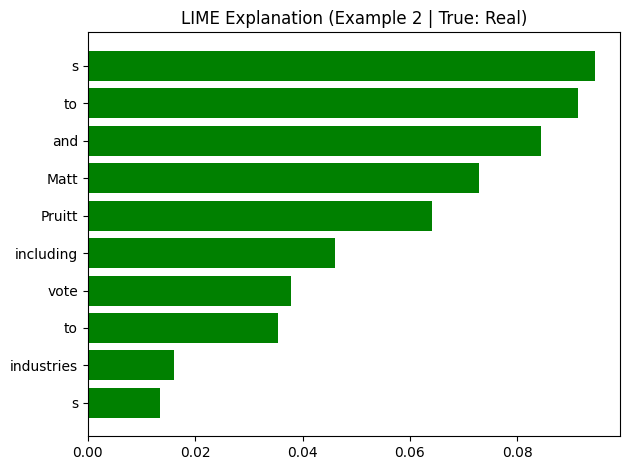

Top Influential Words:
         Word  Contribution
0           s      0.094443
1          to      0.091333
2         and      0.084388
3        Matt      0.072840
4      Pruitt      0.064044
5   including      0.046063
6        vote      0.037897
7          to      0.035367
8  industries      0.016132
9           s      0.013521

--- Explaining Example 3 ---
True Label: Fake
Text Snippet: Joe Piscopo is hysterical! He was on with Neil Cavuto and broke out with imitations of Waters, Sanders and Schiff: And then you got Maxine Waters, Maxine Waters. What is with Maxine Waters. And every ...
Prediction Probabilities -> Fake: 0.9999, Real: 0.0001



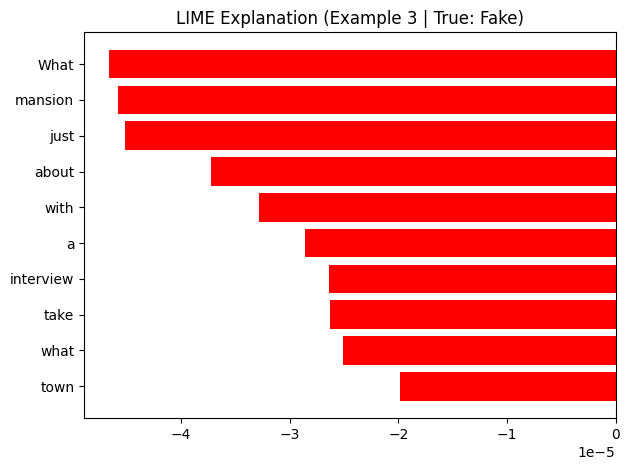

Top Influential Words:
        Word  Contribution
0       What     -0.000047
1    mansion     -0.000046
2       just     -0.000045
3      about     -0.000037
4       with     -0.000033
5          a     -0.000029
6  interview     -0.000026
7       take     -0.000026
8       what     -0.000025
9       town     -0.000020

--- Explaining Example 4 ---
True Label: Fake
Text Snippet: This announcement seems to indicate that the Obama regime already knows Hillary is going to be walking away unscathed from the Benghazi hearings tomorrow Fox News host Andrea Tantaros is pretty sure t...
Prediction Probabilities -> Fake: 0.9999, Real: 0.0001



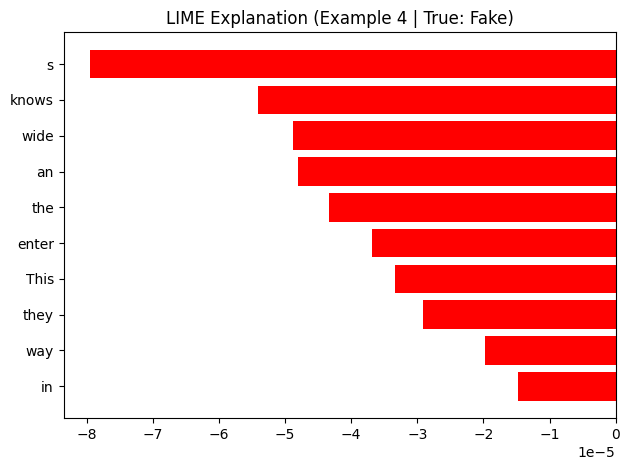

Top Influential Words:
    Word  Contribution
0      s     -0.000080
1  knows     -0.000054
2   wide     -0.000049
3     an     -0.000048
4    the     -0.000043
5  enter     -0.000037
6   This     -0.000033
7   they     -0.000029
8    way     -0.000020
9     in     -0.000015

--- LIME Analysis Complete ---


In [17]:
# Generate LIME Explanations

print("Generating LIME explanations...")

for i, text in enumerate(examples_to_explain):

    print(f"\n--- Explaining Example {i+1} ---")
    print(f"True Label: {true_labels[i]}")
    # Show first 200 chars to verify content
    print(f"Text Snippet: {text[:200]}...")

    # Generate explanation
    exp = explainer.explain_instance(
        text,
        predictor,
        labels=[0, 1],        # Explicitly explain both classes
        num_features=10,      # Top 10 influential words
        num_samples=500       # Higher sample count for stability
    )

    # Display prediction probabilities
    print(
        f"Prediction Probabilities -> "
        f"Fake: {exp.predict_proba[0]:.4f}, "
        f"Real: {exp.predict_proba[1]:.4f}\n"
    )

    # Plot explanation
    fig = exp.as_pyplot_figure()
    plt.title(f"LIME Explanation (Example {i+1} | True: {true_labels[i]})")
    plt.tight_layout()

    # Save figure
    save_path = f"{images_path}lime_explanation_ex{i+1}_{true_labels[i]}.png"
    plt.savefig(save_path, dpi=300)
    plt.show()

    # Print word-level explanation as a DataFrame
    print("Top Influential Words:")
    # Convert list of tuples to DataFrame for clean display
    exp_df = pd.DataFrame(exp.as_list(), columns=['Word', 'Contribution'])
    print(exp_df)

print("\n--- LIME Analysis Complete ---")